# Implementación del sistema de recomendación para una aplicación social 

*Autor: Celeste Castro Granados (celsgazu@ciencias.unam.mx)*

*Fecha de realización: 1 de mayo de 2024*

Este notebook corresponde a la versión final del problema de la predicción de la dinámica de aparición y desaparición de establecimientos minoristas en la Ciudad de México. El sistema propuesto fue desarrollado durante la tesis de Celeste Castro Granados, bajo la supervisión del Dr. Christopher Mejía-Argueta.

## Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

/home/celeste/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sinfo import sinfo
sinfo()

-----
matplotlib  3.6.2
numpy       1.23.5
pandas      1.5.2
seaborn     0.12.2
sinfo       0.3.1
sklearn     1.3.0
torch       1.9.0
torchvision 0.10.0
-----
IPython             8.13.2
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.3
-----
Python 3.9.16 (main, Mar  8 2023, 14:00:05) [GCC 11.2.0]
Linux-3.10.0-1160.36.2.el7.x86_64-x86_64-with-glibc2.17
56 logical CPU cores, x86_64
-----
Session information updated at 2023-12-03 19:59


La celda anterior muestra las versiones de todas las librerías utilizadas en este notebook con el fin de garantizar su reproducibilidad. Asimismo, al ejecutarla se genera automáticamente un archivo txt con dicha información. 

# Planteamiento del Problema

El comercio minorista es la fase final de cualquier actividad económica. El sector minorista destaca como una industria altamente dinámica a nivel mundial, ya que depende de distintos factores. En los países en desarrollo, como México, las megaciudades contribuyen a la formación de un paisaje urbano distintivo, creando circunstancias favorables para la existencia de numerosas tiendas minoristas con diversos formatos. Hay tiendas de canal moderno como Walmart, cadenas de tiendas de conveniencia como 7Eleven u OXXO, o pequeñas tiendas tradicionales normalmente de propiedad familiar también conocidas como tiendas de abarrotes, tienditas o nanotiendas. 

Entender la dinámica de aparición y desaparición de los distintos tipos de establecimientos o tiendas es de vital importancia para los distribuidores y los fabricantes de productos de consumo envasados. 

Se obtuvieron datos entre 2013 y 2022 del Instituto Nacional de Estadística y Geografía (INEGI) y del Directorio Estadístico Nacional de Unidades Económicas (DENUE) de México.

## Importación de las bases de datos

## Base DENUE

In [3]:
base_denue = pd.read_csv('base_denue_recsys_final.csv')
base_denue['año'] = base_denue['key_año'].str.split('_').str[1]
print(base_denue.shape)
base_denue.head()

(25577, 8)


,key,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,año
0,00200010010,00200010010_2015,41,0,0,0.1644,5.0,2015
1,00200010010,00200010010_2016,43,0,0,0.1644,5.0,2016
2,00200010010,00200010010_2017,43,1,0,0.1644,5.0,2017
3,00200010010,00200010010_2018,26,0,0,0.1644,5.0,2018
4,00200010010,00200010010_2019,38,1,0,0.1644,5.0,2019


In [4]:
base_denue['año'].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2013', '2014'], dtype=object)

## Bases INEGI

In [5]:
base_inegi_2020 = pd.read_csv('base_inegi2020_recsys.csv')
base_inegi_2020['año'] = '2020'
base_inegi_2020['key_año'] = base_inegi_2020['key'] + '_' + base_inegi_2020['año']
print(base_inegi_2020.shape)
base_inegi_2020.head()

(2433, 24)


,key,POBFEM,PRESOE15,PHOG_IND,POB_AFRO,P12A14NOA,P8A14AN,GRAPROES,POTRAS_REL,VIVPAR_DES,...,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC,año,key_año
0,00200010010,1695.0,81.0,16.0,98.0,5.0,0.0,11.52,13.0,24.0,...,26.0,865.0,865.0,692.0,824.0,479.0,177.0,14.0,2020,00200010010_2020
1,00200010025,2915.0,141.0,69.0,142.0,31.0,8.0,10.73,33.0,76.0,...,370.0,1759.0,1759.0,1203.0,1614.0,515.0,243.0,68.0,2020,00200010025_2020
2,0020001003A,2232.0,107.0,20.0,13.0,0.0,0.0,10.55,11.0,41.0,...,17.0,1184.0,1184.0,878.0,1070.0,422.0,215.0,12.0,2020,0020001003A_2020
3,00200010044,2551.0,187.0,58.0,123.0,10.0,5.0,11.07,13.0,39.0,...,65.0,1389.0,1389.0,1076.0,1286.0,579.0,245.0,17.0,2020,00200010044_2020
4,00200010097,1115.0,67.0,13.0,12.0,15.0,0.0,11.74,13.0,8.0,...,30.0,596.0,596.0,507.0,562.0,289.0,48.0,3.0,2020,00200010097_2020


Vamos a tomar la base del inegi del 2010 como si fuera del 2015 para poder cruzar con la base del denue de diño año y tener al menos dos años completos.

In [6]:
base_inegi_2015 = pd.read_csv('base_inegi2010_recsys.csv')
base_inegi_2015['año'] = '2015'
base_inegi_2015['key_año'] = base_inegi_2015['key'] + '_' + base_inegi_2015['año']
print(base_inegi_2015.shape)
base_inegi_2015.head()

(2432, 24)


,key,POBFEM,PHOG_IND,P12A14NOA,P8A14AN,GRAPROES,POTRAS_REL,VIVPAR_DES,VIVPAR_UT,VPH_PISODT,...,VPH_INTER,VPH_LAVAD,VPH_AUTOM,PRESOE15,POB_AFRO,VPH_CISTER,VPH_BICI,VPH_SINLTC,año,key_año
0,00200010010,1824,23.0,0.0,4.0,10.67,5.0,15.0,8.0,797.0,...,346.0,762.0,466.0,NaN,NaN,NaN,NaN,NaN,2015,00200010010_2015
1,00200010025,3093,80.0,7.0,4.0,9.79,14.0,79.0,33.0,1556.0,...,523.0,1340.0,532.0,NaN,NaN,NaN,NaN,NaN,2015,00200010025_2015
2,0020001003A,2389,52.0,10.0,0.0,9.56,7.0,45.0,20.0,1085.0,...,395.0,996.0,436.0,NaN,NaN,NaN,NaN,NaN,2015,0020001003A_2015
3,00200010044,2691,37.0,5.0,3.0,10.24,9.0,67.0,17.0,1253.0,...,454.0,1125.0,493.0,NaN,NaN,NaN,NaN,NaN,2015,00200010044_2015
4,00200010097,1184,36.0,0.0,0.0,10.50,0.0,17.0,16.0,553.0,...,259.0,513.0,282.0,NaN,NaN,NaN,NaN,NaN,2015,00200010097_2015


In [7]:
base_inegi = pd.concat([base_inegi_2020,base_inegi_2015])
base_inegi.shape

(4865, 24)

## Juntar ambas bases en una sola

In [8]:
matriz_completa = base_denue.merge(base_inegi, how='left', on='key_año')
matriz_completa = matriz_completa.replace(0,0.00001)
matriz_completa = matriz_completa.fillna(0)
print(matriz_completa.shape)

(25577, 31)


In [9]:
matriz_completa.head()

,key_x,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,año_x,key_y,POBFEM,...,VPH_AGUADV,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC,año_y
0,00200010010,00200010010_2015,41.0,0.00001,0.00001,0.1644,5.0,2015,00200010010,1824.0,...,809.0,0.0,809.0,809.0,346.0,762.0,466.0,0.0,0.0,2015
1,00200010010,00200010010_2016,43.0,0.00001,0.00001,0.1644,5.0,2016,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,00200010010,00200010010_2017,43.0,1.00000,0.00001,0.1644,5.0,2017,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,00200010010,00200010010_2018,26.0,0.00001,0.00001,0.1644,5.0,2018,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,00200010010,00200010010_2019,38.0,1.00000,0.00001,0.1644,5.0,2019,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Construcción de los conjuntos de train, validation y test

Lo primero que vamos a realizar será segmentar en partes iguales las bases con el fin de garantizar que no haya columnas completamente vacías para todos los registros en los conjuntos de datos finales, y que los conjuntos finales estén equilibrados.

In [10]:
def segmentar_base_porcentajes(base, porcentajes):
    base = base.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Calcular los porcentajes deseados
    perc_train = porcentajes[0]
    perc_valid = porcentajes[1]
    perc_test = porcentajes[2]

    # Calcular el número de filas para cada porcentaje
    total_rows = len(base)
    rows_train = int(total_rows * perc_train / 100)
    rows_valid = int(total_rows * perc_valid / 100)
    rows_test = int(total_rows * perc_test / 100)

    # Dividir el DataFrame en tres partes con los porcentajes especificados
    train = base.iloc[:rows_train, :]
    valid = base.iloc[rows_train:rows_train + rows_valid, :]
    test = base.iloc[rows_train + rows_valid: , :]
    
    return train, valid, test

In [11]:
base_2020 = matriz_completa.loc[matriz_completa['año_x'].isin(['2020'])]
base_2015 = matriz_completa.loc[matriz_completa['año_x'].isin(['2015'])]
base_2021 = matriz_completa.loc[matriz_completa['año_x'].isin(['2021'])]
base_2022 = matriz_completa.loc[matriz_completa['año_x'].isin(['2022'])]

In [12]:
base_2020.drop(columns=['key_x', 'año_x', 'key_y', 'año_y'], inplace=True)
base_2015.drop(columns=['key_x', 'año_x', 'key_y', 'año_y'], inplace=True)
base_2021.drop(columns=['key_x', 'año_x', 'key_y', 'año_y'], inplace=True)
base_2022.drop(columns=['key_x', 'año_x', 'key_y', 'año_y'], inplace=True)

/tmp/ipykernel_79284/1235722866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_2020.drop(columns=['key_x', 'año_x', 'key_y', 'año_y'], inplace=True)
/tmp/ipykernel_79284/1235722866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_2015.drop(columns=['key_x', 'año_x', 'key_y', 'año_y'], inplace=True)
/tmp/ipykernel_79284/1235722866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_2021.drop(columns=['key_x', 'año

In [13]:
base_2020_train, base_2020_valid, base_2020_test = segmentar_base_porcentajes(base_2020, [40,40,20])
base_2015_train, base_2015_valid, base_2015_test = segmentar_base_porcentajes(base_2015, [40,40,20])
base_2021_train, base_2021_valid, base_2021_test = segmentar_base_porcentajes(base_2021, [33,33,33])
base_2022_train, base_2022_valid, base_2022_test = segmentar_base_porcentajes(base_2022, [33,33,33])

In [14]:
matriz_train = pd.concat([base_2020_train, base_2015_train, base_2021_train, base_2022_train])
matriz_valid = pd.concat([base_2020_valid, base_2015_valid, base_2021_valid, base_2022_valid])
matriz_test = pd.concat([base_2020_test, base_2015_test, base_2021_test, base_2022_test])

Y volvemos a revolver los renglones para evitar sesgos:

In [15]:
matriz_train = matriz_train.sample(frac=1, random_state=42).reset_index(drop=True)
matriz_valid = matriz_valid.sample(frac=1, random_state=42).reset_index(drop=True)
matriz_test = matriz_test.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
print('Tamaño de la matriz de entrenamiento: ', matriz_train.shape)
print('Tamaño de la matriz de validación: ', matriz_valid.shape)
print('Tamaño de la matriz de prueba: ', matriz_test.shape)

Tamaño de la matriz de entrenamiento:  (3619, 27)
Tamaño de la matriz de validación:  (3619, 27)
Tamaño de la matriz de prueba:  (2687, 27)


In [17]:
#Guardamos las matrices completas
matriz_train.to_csv("train_complete.csv", index=False)
matriz_valid.to_csv("valid_complete.csv", index=False)
matriz_test.to_csv("test_complete.csv", index=False)

Vamos a guardar una segunda vez pero con otros nombres para poder identificar los archivos en el análisis posterior:

In [18]:
#Guardamos las matrices completas
matriz_train.to_csv("train_complete_perc_all.csv", index=False)
matriz_valid.to_csv("valid_complete_perc_all.csv", index=False)
matriz_test.to_csv("test_complete_perc_all.csv", index=False)

### Anular entradas aleatorias en los conjuntos de datos

In [19]:
def anular_entradas(matriz_completa, frac_to_zero):
    entradas_mat = matriz_completa.drop(['key_año'],axis=1)
    keys = matriz_completa['key_año']

    #Obtener el número total de elementos en el DataFrame
    total_elements = entradas_mat.size

    #Calcular el número de elementos a convertir en cero
    num_elements_to_zero = int(total_elements * frac_to_zero)

    #Obtener una lista de índices aleatorios para los elementos a convertir en cero
    np.random.seed(42)
    random_indices = np.random.choice(total_elements, num_elements_to_zero, replace=False)

    #Convertir los elementos en cero basados en los índices generados aleatoriamente
    entradas_mat.values.flat[random_indices] = 0

    entradas_mat.insert(0, 'key_año', keys)
    matriz_incompleta = entradas_mat
    return matriz_incompleta   

In [20]:
def anular_entradas_por_columna(matriz_completa, columnas_por_anular, frac_to_zero):
    matriz_incompleta = matriz_completa.copy()
    #Obtener el número total de elementos en el DataFrame
    total_registros = matriz_incompleta.shape[0]

    #Calcular el número de elementos a convertir en cero
    num_elements_to_zero = int(total_registros * frac_to_zero)

    #Obtener una lista de índices aleatorios para los elementos a convertir en cero
    for i in range(len(columnas_por_anular)):
        #np.random.seed(42)
        col = columnas_por_anular[i]
        random_indices = np.random.choice(total_registros, num_elements_to_zero, replace=False)
        #Convertir los elementos en cero basados en los índices generados aleatoriamente
        matriz_incompleta[col].values.flat[random_indices] = 0
        
    return matriz_incompleta

In [21]:
def conteo_ceros_columna(matriz):
    celdas_cero_por_columna = (matriz == 0).sum()
    return celdas_cero_por_columna

def conteo_ceros_antes_despues(matriz_antes, matriz_despues):
    ceros_antes = conteo_ceros_columna(matriz_antes)
    ceros_despues = conteo_ceros_columna(matriz_despues)
    
    resultados = pd.DataFrame({'Ceros antes de anular entradas random': ceros_antes, 'Ceros despúes de anular entradas random': ceros_despues})
    resultados['Diferencia'] = resultados['Ceros despúes de anular entradas random'] - resultados['Ceros antes de anular entradas random']
    
    return resultados 

In [22]:
def conteo_entradas_cero(matriz, nombre):
    num_zeros = (matriz == 0).sum().sum()
    entradas_totales = matriz.shape[0] * matriz.shape[1]
    porcentaje_entradas_cero = (num_zeros * 100) / entradas_totales
    print(f'Porcentaje de entradas ceros de la matriz de {nombre}: ', f"{porcentaje_entradas_cero:.2f}", '%')   

Cero totales por matriz antes de la anulación de entradas random:

In [23]:
conteo_entradas_cero(matriz_train, 'entrenamiento')
conteo_entradas_cero(matriz_valid, 'validación')
conteo_entradas_cero(matriz_test, 'prueba')

Porcentaje de entradas ceros de la matriz de entrenamiento:  42.65 %
Porcentaje de entradas ceros de la matriz de validación:  42.96 %
Porcentaje de entradas ceros de la matriz de prueba:  53.98 %


Anulación de entradas en columnas específicas:

In [24]:
cols_anular_random = ['nanostores', 'tiendas_conveniencia', 'supermercados', 'area', 'tipo_asent']
matriz_incompleta_cols_train = anular_entradas_por_columna(matriz_train, cols_anular_random, 0.2)
matriz_incompleta_cols_valid = anular_entradas_por_columna(matriz_valid, cols_anular_random, 0.2)

Anulación de entradas aleatorias en general:

In [25]:
matriz_incompleta_train = anular_entradas(matriz_train, 0.2)
matriz_incompleta_valid = anular_entradas(matriz_valid, 0.2)
matriz_incompleta_test = anular_entradas(matriz_test, 0)

Ceros totales por matriz después de la anulación de entradas random: 

In [26]:
conteo_entradas_cero(matriz_incompleta_train, 'entrenamiento incompleta')
conteo_entradas_cero(matriz_incompleta_valid, 'validación incompleta')
conteo_entradas_cero(matriz_incompleta_test, 'prueba incompleta')

Porcentaje de entradas ceros de la matriz de entrenamiento incompleta:  53.43 %
Porcentaje de entradas ceros de la matriz de validación incompleta:  53.69 %
Porcentaje de entradas ceros de la matriz de prueba incompleta:  53.98 %


In [27]:
conteo_entradas_cero(matriz_incompleta_cols_train, 'entrenamiento incompleta')
conteo_entradas_cero(matriz_incompleta_cols_valid, 'validación incompleta')

Porcentaje de entradas ceros de la matriz de entrenamiento incompleta:  46.30 %
Porcentaje de entradas ceros de la matriz de validación incompleta:  46.61 %


Ceros por columna antes y despúes:

Train:

In [28]:
print('Total de registros: ', matriz_train.shape[0])
conteo_ceros_antes_despues(matriz_train, matriz_incompleta_train)

Total de registros:  3619


,Ceros antes de anular entradas random,Ceros despúes de anular entradas random,Diferencia
key_año,0,0,0
nanostores,0,728,728
tiendas_conveniencia,0,735,735
supermercados,0,743,743
area,220,920,700
tipo_asent,0,731,731
POBFEM,1752,2127,375
PRESOE15,2685,2863,178
PHOG_IND,1752,2138,386
POB_AFRO,2685,2873,188


In [29]:
print('Total de registros: ', matriz_train.shape[0])
conteo_ceros_antes_despues(matriz_train, matriz_incompleta_cols_train)

Total de registros:  3619


,Ceros antes de anular entradas random,Ceros despúes de anular entradas random,Diferencia
key_año,0,0,0
nanostores,0,723,723
tiendas_conveniencia,0,723,723
supermercados,0,723,723
area,220,896,676
tipo_asent,0,723,723
POBFEM,1752,1752,0
PRESOE15,2685,2685,0
PHOG_IND,1752,1752,0
POB_AFRO,2685,2685,0


Valid:

In [30]:
print('Total de registros: ', matriz_valid.shape[0])
conteo_ceros_antes_despues(matriz_valid, matriz_incompleta_valid)

Total de registros:  3619


,Ceros antes de anular entradas random,Ceros despúes de anular entradas random,Diferencia
key_año,0,0,0
nanostores,0,728,728
tiendas_conveniencia,0,735,735
supermercados,0,743,743
area,245,947,702
tipo_asent,0,731,731
POBFEM,1766,2138,372
PRESOE15,2695,2877,182
PHOG_IND,1766,2147,381
POB_AFRO,2695,2871,176


In [31]:
print('Total de registros: ', matriz_valid.shape[0])
conteo_ceros_antes_despues(matriz_valid, matriz_incompleta_cols_valid)

Total de registros:  3619


,Ceros antes de anular entradas random,Ceros despúes de anular entradas random,Diferencia
key_año,0,0,0
nanostores,0,723,723
tiendas_conveniencia,0,723,723
supermercados,0,723,723
area,245,917,672
tipo_asent,0,723,723
POBFEM,1766,1766,0
PRESOE15,2695,2695,0
PHOG_IND,1766,1766,0
POB_AFRO,2695,2695,0


Y guardamos como csv:

In [32]:
matriz_incompleta_cols_train.to_csv("train_incomplete.csv", index=False)
matriz_incompleta_cols_valid.to_csv("valid_incomplete.csv", index=False)
matriz_incompleta_test.to_csv("test_incomplete.csv", index=False)

Volvemos a guardar una segunda vez:

In [33]:
matriz_incompleta_cols_train.to_csv("train_incomplete_perc_all.csv", index=False)
matriz_incompleta_cols_valid.to_csv("valid_incomplete_perc_all.csv", index=False)
matriz_incompleta_test.to_csv("test_incomplete_perc_all.csv", index=False)

## Train y Test Dataset Class Implementacion

A partir de esta sección, se puede ejecutar directamente sin necesidad de correr las secciones anteriores.

In [32]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import seaborn as sns 

Antes de iniciar con la implementación de las clases, es necesario definir una variable que indique el número de GPU a utilizar, esto con el fin de no tener que cambiarlo en cada línea cada vez.  

In [33]:
num_gpu = 2

Las clases que se construyen a continuación se utilizan para cargar los conjuntos de datos en el formato requerido a partir de los archivos CSV. El constructor de la clase toma el nombre del archivo CSV y una función de transformación opcional como argumentos. La función de transformación se aplica a los datos del archivo CSV. Si no se proporciona ninguna función de transformación, los datos se devuelven sin cambios.

### TestDataset


In [34]:
# Definir la clase TestDataset
class TestDataset(Dataset):
    def __init__(self, test_file, transform=None):
        # Cargar los datos del archivo CSV y elimina la primera columna
        #Al final los datos a completar se encuentran en las columnas de las propiedades y no en la que contiene la información del key_año
        self.data = pd.read_csv(test_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        
        # Aplicar la función de transformación si se proporciona
        if transform is not None:
            self.data = self.transform(np.array(self.data))
        
    def __len__(self):
        # Devolver la longitud del conjunto de datos de prueba
        return len(self.data[0])
    
    def __getitem__(self, ind):
        # Devolver el vector de compuesto correspondiente al índice especificado
        user_vector = self.data.data[0][ind]
        return user_vector

### TrainDataset

In [35]:
# Definir la clase TrainDataset
class TrainDataset(Dataset):
    def __init__(self, train_file, transform=None):
        # Cargar los datos del archivo CSV y elimina la primera columna
        #Al final los datos a completar se encuentran en las columnas de las propiedades y no en la que contiene la información del key_año
        self.data = pd.read_csv(train_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        
        # Aplicar la función de transformación si se proporciona
        if transform is not None:
            self.data = self.transform(np.array(self.data))
        
    def __len__(self):
        # Devolver la longitud del conjunto de datos de entrenamiento
        return len(self.data[0])
    
    def __getitem__(self, ind):
        # Devolver el vector de compuesto correspondiente al índice especificado
        user_vector = self.data.data[0][ind]
        return user_vector

## Loss Function

In [36]:
import torch
import torch.nn as nn
from torch.autograd import Variable

Definimos ahora otra clase llamada MSEloss_with_Mask, la cual va a calcular la función de pérdida Mean Squared Error (MSE) para el modelo de filtrado colaborativo, considerando que algunas entradas están enmascaradas. En un modelo de filtrado colaborativo, las entradas enmascaradas se refieren a los elementos del conjunto de datos que se han ocultado o eliminado temporalmente para evaluar el rendimiento del modelo en un conjunto de datos de prueba. Estas entradas enmascaradas pueden ser ocultadas para realizar una validación cruzada o para prevenir el sobreajuste del modelo a los datos de entrenamiento.

In [37]:
class MSEloss_with_Mask(nn.Module):
  #Esta clase hereda de la clase nn.Module de PyTorch
  def __init__(self):
    super(MSEloss_with_Mask,self).__init__()

  def forward(self,inputs, targets):
    #inputs, targets - entradas y salidas del modelo respectivamente 
    # Enmascaramiento en un vector de 1's y 0's.
    mask = (targets!=0)
    mask = mask.float()

    # Número real de datos en la matriz.
    # Se toma el máximo para evitar la división por cero en el cálculo de la pérdida.
    other = torch.Tensor([1.0])
    other = other.cuda(num_gpu)
    number_ratings = torch.max(torch.sum(mask),other)

    # Cálculo del error cuadrático medio (MSE) y la pérdida
    error = torch.sum(torch.mul(mask,torch.mul((targets-inputs),(targets-inputs))))
    loss = error.div(number_ratings)

    return loss[0]

El proceso de enmascaramiento se realiza con el objetivo de que el modelo no aprenda de las entradas con valor cero y se provoque un sesgo en el mismo, pues estas son justamente las que queremos predecir.

In [38]:
#Propuesta de función de pérdida en el paper de NVIDIA
#def MSEloss(inputs, targets, size_average=False):
  #mask = targets != 0
  #num_ratings = torch.sum(mask.float())
  #criterion = nn.MSELoss(reduction='sum' if not size_average else 'mean')
  #return criterion(inputs * mask.float(), targets), Variable(torch.Tensor([1.0])) if size_average else num_ratings

### RMSE

La función de pérdida calcula el MMSE (Mask Mean Square Error), sin embargo, definiremos también una función que calcule el RMSE como métrica de evaluación al desempeño del modelo. El RMSE corresponde a la raíz cuadrada del MMSE. 

In [39]:
def calcular_rmse(mmse):
    rmse = np.sqrt(mmse)
    return rmse 
    

## Modelo Autoencoder

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

Un autoencoder es una red neuronal que tiene como objetivo aprender una representación latente de los datos de entrada, de tal manera que se puedan reconstruir los datos originales a partir de esta representación. Este proceso, permite completar los valores faltantes en los datos originales. 

<div>
<img src="/home/celeste/tesis/recommender/Recommender-NVIDIA/imagenes_notebook/autoencoder.jpg" width='600'/>
</div>

Definición de la función de activación:

In [41]:
def activation(input, type):
  
    if type.lower()=='selu':
        return F.selu(input)
    elif type.lower()=='elu':
        return F.elu(input)
    elif type.lower()=='relu':
        return F.relu(input)
    elif type.lower()=='relu6':
        return F.relu6(input)
    elif type.lower()=='lrelu':
        return F.leaky_relu(input)
    elif type.lower()=='tanh':
        return F.tanh(input)
    elif type.lower()=='sigmoid':
        return F.sigmoid(input)
    elif type.lower()=='swish':
        return F.sigmoid(input)*input
    elif type.lower()=='identity':
        return input
    else:
        raise ValueError("Unknown non-Linearity Type")

In [42]:
funciones_activation = ['selu', 'elu', 'relu', 'relu6', 'lrelu', 'tanh', 'sigmoid', 'swish', 'identity']

Construcción de la clase AutoEncoder:

In [43]:
class AutoEncoder(nn.Module):
    # Constructor de la clase, recibe como parámetros layer_sizes, nl_type, is_constrained, dp_drop_prob y last_layer_activations
    def __init__(self, layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=True):
        """
        layer_sizes = tamaño de cada capa en el modelo de encoder. Should start with feature size (e.g. dimensionality of x)
        Por ejemplo: [10000, 1024, 512] resultará en:
            - 2 capas de encoder: 10000x1024 y 1024x512. La capa de representación (z) será de 512.
            - 2 capas de decoder: 512x1024 y 1024x10000.
    
        nl_type = tipo de no linealidad (por defecto: 'selu').
        is_constrained = Si es verdadero, entonces los pesos del encoder y decoder están atados.
        dp_drop_prob = probabilidad de Dropout.
        last_layer_activations = Si es verdadero, se aplica una activación en la última capa del decoder.
        """

        # Llama al constructor de la clase padre (nn.Module)
        super(AutoEncoder, self).__init__()

        # Asignación de parámetros a variables de la instancia
        self.layer_sizes = layer_sizes
        self.nl_type = nl_type
        self.is_constrained = is_constrained
        self.dp_drop_prob = dp_drop_prob
        self.last_layer_activations = last_layer_activations

        # Si dp_drop_prob > 0, se inicializa una instancia de Dropout
        if dp_drop_prob>0:
            self.drop = nn.Dropout(dp_drop_prob)

        self._last = len(layer_sizes) - 2

        # Inicialización de pesos del encoder
        self.encoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(layer_sizes[i+1], layer_sizes[i])) for i in range(len(layer_sizes) - 1)  ] )

        # "Inicialización Xavier" (Entendiendo la dificultad en entrenar redes neuronales profundas de alimentación directa - por Glorot, X. & Bengio, Y.)
        # (Los valores se muestrean a partir de una distribución uniforme)
        for weights in self.encoder_weights:
            init.xavier_uniform_(weights)

        # Bias del encoder
        self.encoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(layer_sizes[i+1])) for i in range(len(layer_sizes) - 1) ] )

        # Lista de layer_sizes invertida
        reverse_layer_sizes = list(reversed(layer_sizes)) 
        # reversed retorna un iterador

        # Inicialización de pesos del decoder si is_constrained es falso
        if is_constrained == False:
            self.decoder_weights = nn.ParameterList( [nn.Parameter(torch.rand(reverse_layer_sizes[i+1], reverse_layer_sizes[i])) for i in range(len(reverse_layer_sizes) - 1) ] )

            # Inicialización Xavier de los pesos del decoder
            for weights in self.decoder_weights:
                init.xavier_uniform_(weights)

        # Bias del decoder
        self.decoder_bias = nn.ParameterList( [nn.Parameter(torch.zeros(reverse_layer_sizes[i+1])) for i in range(len(reverse_layer_sizes) - 1) ] ) 
    
    
    def encode(self, x):
     #Realiza la codificación de la entrada x'
     # Recorremos la lista de pesos del codificador
        for i, w in enumerate(self.encoder_weights):
            # Aplicamos la operación de multiplicación matricial entre la entrada x y el peso w del codificador, y sumamos el sesgo correspondiente
            x = F.linear(input=x, weight=w, bias=self.encoder_bias[i])
            # Aplicamos la función de activación correspondiente al tipo de no linealidad definida
            x = activation(input=x, type=self.nl_type)

        # Aplicamos Dropout en la última capa, si se define una probabilidad de eliminación de nodos
        if self.dp_drop_prob > 0:
            x = self.drop(x)

    # Retornamos el tensor resultante
        return x
    
    def build_latent_rep(self,x):
        #Obtiene la representación latente de nuevos datos una vez que el encoder ya está entrenado
        self.eval()
        x=self.encode(x)
        #será necesario agregar el paso de x = x.detach().numpy()?
        return x 


    def decode(self, x):
        # Si se trata de un modelo con pesos atados, se aplica la operación de decodificación con los pesos del codificador invertidos
        if self.is_constrained == True:
            # Los pesos están atados, por lo que recorremos los pesos del codificador en orden inverso
            for i, w in zip(range(len(self.encoder_weights)), list(reversed(self.encoder_weights))):
                # Aplicamos la operación de multiplicación matricial entre la entrada x y el peso w del decodificador, y sumamos el sesgo correspondiente
                x = F.linear(input=x, weight=w.t(), bias=self.decoder_bias[i])
                # Aplicamos la función de activación correspondiente al tipo de no linealidad definida, excepto para la última capa si se define que no tenga activación
                x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'identity')

        else:
            # Los pesos no están atados, por lo que recorremos los pesos del decodificador
            for i, w in enumerate(self.decoder_weights):
                # Aplicamos la operación de multiplicación matricial entre la entrada x y el peso w del decodificador, y sumamos el sesgo correspondiente
                x = F.linear(input=x, weight=w, bias=self.decoder_bias[i])
                # Aplicamos la función de activación correspondiente al tipo de no linealidad definida, excepto para la última capa si se define que no tenga activación
                x = activation(input=x, type=self.nl_type if i != self._last or self.last_layer_activations else 'identity')

    # Retornamos el tensor resultante
        return x


    def forward(self, x):
        return self.decode(self.encode(x))

## Funciones para preparar los datos, ejecutar el entrenamiento y realizar predicciones

In [44]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from livelossplot import PlotLosses

Función que ejecuta el flujo de preparación de nuevos datos para poder hacer predicciones:

In [45]:
def prepare_newdata(ruta_datos, batch_size, num_workers=0):
    #preparar los datos para poder ingresarlos al modelo
    transformations = transforms.Compose([transforms.ToTensor()])
    test_dat = TestDataset(ruta_datos, transformations)
    test_dl = DataLoader(dataset=test_dat, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return test_dl
    

Definición de una función que nos permitirá realizar el proceso de entrenamiento del modelo. 


In [46]:
def train(model, criterion, optimizer, train_dl, test_dl, num_epochs=40):
  # Definimos la función "train" que toma como entrada un modelo, un criterio de pérdida, un optimizador, 
  # un conjunto de entrenamiento y un conjunto de pruebas, y un número de épocas.

  # Inicializamos la biblioteca livelossplot para graficar en tiempo real la pérdida de entrenamiento y validación
  liveloss = PlotLosses()
  
  #Listas de pérdidas de entrenamiento y validación
  lr_tr_loss = []
  lr_val_loss= []
  
  # Iteramos sobre cada época
  for epoch in range(num_epochs):
    
    #Matrices completas
    matrix_out_train = torch.Tensor([])
    matrix_out_test = torch.Tensor([])
    
    # Creamos dos listas vacías para guardar la pérdida de entrenamiento y la de validación en cada época
    train_loss, valid_loss = [], []
    
    # Creamos un diccionario vacío para guardar los registros de la pérdida en la biblioteca livelossplot
    logs = {}
    
    # Definimos un prefijo para los registros (en este caso, vacío)
    prefix = ''

    # Entrenamiento
    # Ponemos el modelo en modo de entrenamiento
    model.train()
    
    # Iteramos sobre los datos en el conjunto de entrenamiento
    for i, data in enumerate(train_dl, 0):
      # Obtenemos los datos de entrada y las etiquetas
      inputs = labels = data
      
      # Enviamos los datos a la GPU si está disponible
      inputs = inputs.cuda(num_gpu)
      labels = labels.cuda(num_gpu)

      # Convertimos los datos en tensores flotantes
      inputs = inputs.float() 
      labels = labels.float()

      # Ponemos los gradientes en cero
      optimizer.zero_grad()

      # Se aplica la función forward a inputs 
      outputs = model(inputs)
      
      # Enviamos la salida del modelo a la GPU si está disponible
      outputs = outputs.cuda(num_gpu)
      
      # Calculamos la pérdida
      loss = criterion(outputs,labels)
      
      # Realizamos el retroceso
      loss.backward()
      
      # Actualizamos los pesos
      optimizer.step()

      # -> Re-alimentación densa iterativa de salida <- #
      
      # Ponemos los gradientes en cero
      optimizer.zero_grad()
      
      # Es importante "detach()" la salida para evitar la construcción innecesaria del grafo computacional
      outputs = model(outputs.detach()) 
      #revisar si la salida del modelo está en cpu
      
      # Enviamos la salida a la GPU si está disponible
      outputs = outputs.cuda(num_gpu)
      
      # Calculamos la pérdida
      loss = criterion(outputs, labels)
      
      # Realizamos el retroceso
      loss.backward()
      
      # Actualizamos los pesos
      optimizer.step()

      # Guardamos la pérdida de entrenamiento en la lista "train_loss"
      train_loss.append(loss.item())
      
      # Guardamos la pérdida en el diccionario de registros
      logs[prefix + 'MMSE loss'] = loss.item()
      
      outputs = outputs.to('cpu')
      #Guardamos el batch reconstruido de entrenamiento
      matrix_out_train = torch.cat([matrix_out_train, outputs], 0)
      
      # Iterar a través de los datos de test_dl utilizando el índice i comenzando desde 0.
    for i, data in enumerate(test_dl, 0):
      # Establecer el modelo en modo de evaluación.
      model.eval()
      # Asignar los datos a las variables inputs y labels.
      inputs = labels = data
      # Mover las variables inputs y labels a la GPU si está disponible.
      inputs = inputs.cuda(num_gpu)
      labels = labels.cuda(num_gpu)

      # Convertir las variables inputs y labels a float.
      inputs = inputs.float()
      labels = labels.float()

      # Calcular las predicciones utilizando el modelo con las variables inputs.
      outputs = model(inputs)
      # Mover las predicciones a la GPU si está disponible.
      outputs = outputs.cuda(num_gpu)
      # Calcular la pérdida utilizando las predicciones y las etiquetas.
      loss = criterion(outputs, labels)

      # Agregar la pérdida a la lista de pérdidas de validación.
      valid_loss.append(loss.item())
      # Establecer el prefijo como 'val_'
      prefix = 'val_'
      # Agregar la pérdida a los registros con el prefijo.
      logs[prefix + 'MMSE loss'] = loss.item()
      
      #Guardamos el batch reconstruido de entrenamiento
      outputs = outputs.to('cpu')
      matrix_out_test = torch.cat([matrix_out_test, outputs], 0)

    # Calcular la media de las pérdidas de entrenamiento y agregarla a la lista de pérdidas de entrenamiento.
    lr_tr_loss.append(np.mean(train_loss))
    # Calcular la media de las pérdidas de validación y agregarla a la lista de pérdidas de validación.
    lr_val_loss.append(np.mean(valid_loss))
    # Actualizar los registros utilizando la librería liveloss.
    liveloss.update(logs)
    # Dibujar el gráfico utilizando la librería liveloss.
    #liveloss.draw()
    liveloss.send()

    # Imprimir el número de la época actual y la pérdida de entrenamiento y validación promedio.
    print("Epoch:", epoch+1, " Training Loss: ", np.mean(train_loss), " Valid Loss: ", np.mean(valid_loss))
    
    # Si la época actual es la última, devolver las predicciones.
    if epoch == num_epochs -1:
      return matrix_out_train, matrix_out_test, lr_tr_loss, lr_val_loss

Las listas `lr_tr_loss` y `lr_val_loss` contienen los valores de la pérdida a lo largo del entrenamiento (el promedio para cada época). Nos servirán para poder graficar el comportamiento de dicha pérdida incluso después de haber realizado el entrenamiento. El último valor contenido en cada lista, corresponderá a la pérdida asociada al final del entrenamiento, y será a este valor al que se le calculará el RMSE posteriormente. 

Función para realizar predicciones cuando lleguen nuevos datos:

In [47]:
def predict(model, criterion, test_dl):
    lr_val_loss= []
    matrix_out_test = torch.Tensor([])
    valid_loss = []
    
    # Iterar a través de los batches de los datos utilizando el índice i comenzando desde 0.
    for i, data in enumerate(test_dl, 0):
      # Establecer el modelo en modo de evaluación.
      model.eval()
      # Asignar los datos a las variables inputs y labels.
      inputs = labels = data
      # Mover las variables inputs y labels a la GPU si está disponible.
      inputs = inputs.cuda(num_gpu)
      labels = labels.cuda(num_gpu)

      # Convertir las variables inputs y labels a float.
      inputs = inputs.float()
      labels = labels.float()

      # Calcular las predicciones utilizando el modelo con las variables inputs.
      outputs = model(inputs)
      # Mover las predicciones a la GPU si está disponible.
      outputs = outputs.cuda(num_gpu)
      # Calcular la pérdida utilizando las predicciones y las etiquetas.
      loss = criterion(outputs, labels)

      # Agregar la pérdida a la lista de pérdidas de validación.
      valid_loss.append(loss.item())
      
      #Guardamos el batch reconstruido de entrenamiento
      outputs = outputs.to('cpu')
      #Vamos concatenando los batches para recuperar la matriz original
      matrix_out_test = torch.cat([matrix_out_test, outputs], 0)
    
    # Imprimir el número de la época actual y la pérdida promedio para todos los batches. 
    print("Loss (MMSE): ", np.mean(valid_loss))
    print('Matrix shape: ', matrix_out_test.shape)
    print('RMSE: ', np.sqrt(np.mean(valid_loss))) #debe ser el último valor o el promedio?
    
    return matrix_out_test
    

## Proceso de implementación 

In [48]:
import torch
import torchvision
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from livelossplot import PlotLosses


Se importan los archivos correspondientes a los conjuntos de train y validación para el proceso de entrenamiento. Sin embargo, serán nombrados como train y test, pues con esos nombres fueron construidas las clases.

In [49]:
ruta_train_completo = '/home/celeste/tesis/tienditas/segundas_pruebas_RecSys/train_complete.csv'
ruta_test_completo = '/home/celeste/tesis/tienditas/segundas_pruebas_RecSys/valid_complete.csv'

ruta_train = '/home/celeste/tesis/tienditas/segundas_pruebas_RecSys/train_incomplete.csv'
ruta_test = '/home/celeste/tesis/tienditas/segundas_pruebas_RecSys/valid_incomplete.csv'

In [50]:
train_completo = pd.read_csv(ruta_train_completo)
test_completo = pd.read_csv(ruta_test_completo)

In [51]:
train_original = pd.read_csv(ruta_train)
test_original = pd.read_csv(ruta_test)

print(train_original.shape)
print(test_original.shape)

(3619, 27)
(3619, 27)


In [52]:
train_original.head()

,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,POBFEM,PRESOE15,PHOG_IND,POB_AFRO,...,VPH_C_ELEC,VPH_AGUADV,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC
0,00500011383_2021,126.0,1.00000,0.00001,0.2140,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01600010548_2021,4.0,2.00000,0.00001,0.0000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00700015605_2021,20.0,0.00001,0.00001,0.3971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00500011788_2022,0.0,2.00000,0.00001,0.1943,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01300011440_2022,73.0,0.00000,0.00001,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
test_original.head()

,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,POBFEM,PRESOE15,PHOG_IND,POB_AFRO,...,VPH_C_ELEC,VPH_AGUADV,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC
0,00500010012_2021,0.0,0.00001,0.00001,0.0000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01000011985_2021,36.0,0.00001,0.00000,0.0922,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00901610100_2021,4.0,0.00001,0.00001,0.0000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01000011345_2022,105.0,1.00000,0.00000,0.5700,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0070001198A_2022,91.0,1.00000,1.00000,0.2601,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creación de objetos de las clases 

In [54]:
transformations = transforms.Compose([transforms.ToTensor()])

In [55]:
train_dat = TrainDataset(ruta_train, transformations)

print("Training Length: ", train_dat.__len__())

Training Length:  3619


In [56]:
test_dat = TestDataset(ruta_test, transformations)

print("Testing Length: ", test_dat.__len__())

Testing Length:  3619


## Dataloader

In [57]:
train_dl = DataLoader(dataset=train_dat, batch_size = 128, shuffle=False, num_workers = 0)


In [58]:
test_dl = DataLoader(dataset=test_dat, batch_size=64, shuffle=False, num_workers=0)


## Model

El número de neuronas que debe tener la primera capa del modelo corresponde al `número de columnas` de la matriz de entrada.

In [59]:
layer_sizes = [26, 20, 16, 12]

Como buscamos una representación latente de los datos de entrada, conviene escoger como número de neuronas de las capas ocultas, una cantidad menor que las asociadas a la capa de entrada. 

In [60]:
funciones_activation

['selu',
 'elu',
 'relu',
 'relu6',
 'lrelu',
 'tanh',
 'sigmoid',
 'swish',
 'identity']

In [61]:
model= AutoEncoder(layer_sizes=layer_sizes, nl_type='relu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=False)
#movemos el modelo a la GPU
model = model.cuda(num_gpu)

Comportamiento de las funciones de activación:

La condición de `is constrained` disminuye notablemente los valores de pérdida.
se opta por la función de activación `relu`, porque corresponde a la propuesta en el artículo.

In [62]:
# Loss Function

criterion = MSEloss_with_Mask()
criterion = criterion.cuda(num_gpu)

Forzosamente si se debe utilizar la función de pérdida enmascarada, puesto que si se opta por la normal MSE, aunque los valores de pérdida reduzcan notoriamente, las entradas en cero se mantienen exactamente igual después del entrenamiento. 

In [63]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#0.001

In [64]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
encoder_weights.0 	 torch.Size([20, 26])
encoder_weights.1 	 torch.Size([16, 20])
encoder_weights.2 	 torch.Size([12, 16])
encoder_bias.0 	 torch.Size([20])
encoder_bias.1 	 torch.Size([16])
encoder_bias.2 	 torch.Size([12])
decoder_bias.0 	 torch.Size([16])
decoder_bias.1 	 torch.Size([20])
decoder_bias.2 	 torch.Size([26])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8]}]


Comprobemos que se está utilizando la gpu:

In [65]:
torch.cuda.is_available()

True

## Fitting the Model 

In [66]:
#esta celda sirve para detener la ejecución de todo el flujo y evitar mandar a correr los entrenamientos nuevamente 
#stop

Procedemos a entrenar el modelo:

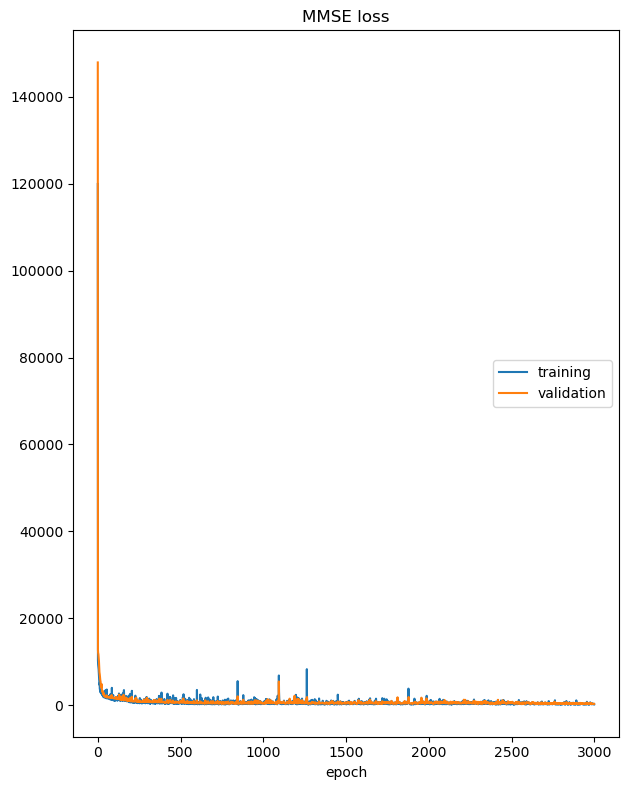

MMSE loss
	training         	 (min:  112.762, max: 119966.180, cur:  163.281)
	validation       	 (min:  250.138, max: 147949.406, cur:  280.248)
Epoch: 3000  Training Loss:  413.9041484964305  Valid Loss:  398.09358483030087


In [67]:
out_train, out_test, lr_tr_loss, lr_val_loss = train(model, criterion, optimizer, train_dl, test_dl, 3000)  

In [68]:
min_valor_train = np.min(train_original.drop(columns='key_año'))
max_valor_train = np.max(train_original.drop(columns='key_año'))
rango_train = max_valor_train - min_valor_train

min_valor_test = np.min(test_original.drop(columns='key_año'))
max_valor_test = np.max(test_original.drop(columns='key_año'))
rango_test = max_valor_test - min_valor_test

print(f"El rango de valores en el arreglo de train es: {rango_train}")
print(f"El rango de valores en el arreglo de test es: {rango_test}")

El rango de valores en el arreglo de train es: nanostores              2653.00
tiendas_conveniencia      15.00
supermercados             11.00
area                       7.44
tipo_asent                 5.00
POBFEM                  7701.00
PRESOE15                1174.00
PHOG_IND                1430.00
POB_AFRO                1101.00
P12A14NOA                 73.00
P8A14AN                   36.00
GRAPROES                  15.67
POTRAS_REL              2346.00
VIVPAR_DES               861.00
VIVPAR_UT                491.00
VPH_PISODT              4246.00
VPH_C_ELEC              4250.00
VPH_AGUADV              4249.00
VPH_CISTER              3699.00
VPH_EXCSA               4249.00
VPH_DRENAJ              4250.00
VPH_INTER               3662.00
VPH_LAVAD               3831.00
VPH_AUTOM               2486.00
VPH_BICI                1083.00
VPH_SINLTC               205.00
dtype: float64
El rango de valores en el arreglo de test es: nanostores               2026.00
tiendas_conveniencia       

/home/celeste/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/celeste/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/celeste/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwa

In [68]:
import pickle

#Guardar las listas de los valores de pérdida y las matrices de salida: out_train, out_test, lr_tr_loss, lr_val_loss
with open('train_loss_perc_all_3000.pickle', 'wb') as f:
    pickle.dump(lr_tr_loss, f)
    
with open('test_loss_perc_all_3000.pickle', 'wb') as f:
    pickle.dump(lr_val_loss, f)
    
with open('out_train_perc_all_3000.pickle', 'wb') as f:
    pickle.dump(out_train, f)

with open('out_test_perc_all_3000.pickle', 'wb') as f:
    pickle.dump(out_test, f)

In [69]:
#Guardar el modelo 
torch.save(model.state_dict(),'model_perc_all_3000.pt')

In [ ]:
#Guardar el modelo ya entrenado (sólo se puede recuperar para inferencia)
#torch.save(model, 'model.pt') revisar si con esta forma de guardar permite predecir para datos que no tengan las mismas dimensiones que la matriz de entrenamienton 

#Guardar el modelo para después seguirlo entrenando
#torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'loss': loss,}, PATH)

*Para más información sobre como guardar y cargar un modelo: https://pytorch.org/tutorials/beginner/saving_loading_models.html*

# Resultados

In [70]:
import pickle
import matplotlib.pyplot as plt

### Plot Training and Validation Loss 

Por último, antes de pasar a analizar los resultados obtenidos, vamos a graficar nuevamente la pérdida de entrenamiento y validación, pero esta vez buscando mayor calidad en la gráfica.

In [70]:
#Cargar las listas que contienen los valores de pérdida
with open('train_loss_perc_all_3000.pickle', 'rb') as f:
    lr_tr_loss = pickle.load(f)
    
with open('test_loss_perc_all_3000.pickle', 'rb') as f:
    lr_val_loss = pickle.load(f)

<function matplotlib.pyplot.show(close=None, block=None)>

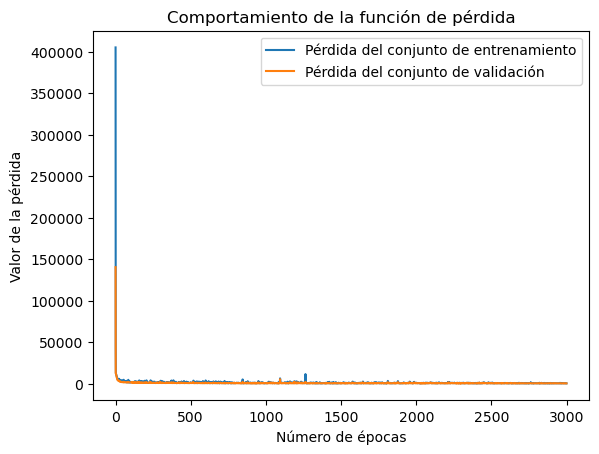

In [71]:
sns.lineplot(lr_tr_loss, label='Pérdida del conjunto de entrenamiento')
sns.lineplot(lr_val_loss,label='Pérdida del conjunto de validación')
#plt.plot(lr_tr_loss, label='train_loss')
#plt.plot(lr_val_loss,label='val_loss')
plt.legend()
plt.title('Comportamiento de la función de pérdida')
plt.xlabel('Número de épocas')
plt.ylabel('Valor de la pérdida')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

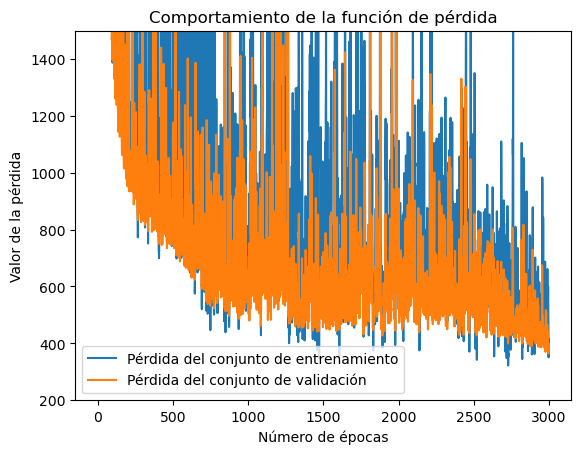

In [77]:
sns.lineplot(lr_tr_loss, label='Pérdida del conjunto de entrenamiento')
sns.lineplot(lr_val_loss,label='Pérdida del conjunto de validación')

#plt.plot(lr_tr_loss, label='train_loss')
#plt.plot(lr_val_loss,label='val_loss')
plt.legend()
#plt.grid()
plt.title('Comportamiento de la función de pérdida')
plt.xlabel('Número de épocas')
plt.ylabel('Valor de la pérdida')
plt.ylim(200,1500)
plt.show

RMSE

In [78]:
rmse_train = calcular_rmse(lr_tr_loss[-1]) #lo calculamos para el último valor de la lista, i.e. la pérdida registrada en la última época
rmse_test = calcular_rmse(lr_val_loss[-1])

print('RMSE train: ', rmse_train)
print('RMSE test: ', rmse_test)

RMSE train:  20.344634390827242
RMSE test:  19.95228269723294


### Análisis de la salida del modelo

Cargamos el modelo y las matrices de salida guardadas durante el entrenamiento:

In [79]:
#Load the model (Model class must be defined somewhere)
#model = torch.load('model_relu.pt')
model.load_state_dict(torch.load('model_perc_all_3000.pt'))
model.eval()

AutoEncoder(
  (encoder_weights): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 20x26 (GPU 2)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 16x20 (GPU 2)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 12x16 (GPU 2)]
  )
  (encoder_bias): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 20 (GPU 2)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 16 (GPU 2)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 12 (GPU 2)]
  )
  (decoder_bias): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 16 (GPU 2)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 20 (GPU 2)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 26 (GPU 2)]
  )
)

In [80]:
with open('out_train_perc_all_3000.pickle', 'rb') as f:
    out_train = pickle.load(f)

with open('out_test_perc_all_3000.pickle', 'rb') as f:
    out_test = pickle.load(f)

## Revisión de la salida del modelo con respecto a los datos originales

In [81]:
def reconstruir_salida(matriz_original, salida_modelo):
    columnas = matriz_original.drop(['key_año'],axis=1).columns
    keys = matriz_original['key_año']
    
    salida = salida_modelo.detach().numpy()
    salida = pd.DataFrame(salida, columns=columnas)
    salida.insert(0, 'key_año', keys)
    
    return salida 

Matrices de entrenamiento:

In [82]:
train_original

,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,POBFEM,PRESOE15,PHOG_IND,POB_AFRO,...,VPH_C_ELEC,VPH_AGUADV,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC
0,00500011383_2021,126.0,1.00000,0.00001,0.2140,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01600010548_2021,4.0,2.00000,0.00001,0.0000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00700015605_2021,20.0,0.00001,0.00001,0.3971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00500011788_2022,0.0,2.00000,0.00001,0.1943,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01300011440_2022,73.0,0.00000,0.00001,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,00900810100_2015,2.0,0.00000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3615,00200010595_2015,88.0,0.00001,0.00001,0.2119,5.0,2392.0,0.0,139.0,0.0,...,1215.0,1212.0,0.0,1214.0,1213.0,373.0,903.0,478.0,0.0,0.0
3616,00902890524_2020,1.0,0.00001,0.00000,0.0000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3617,01000011129_2022,13.0,0.00000,2.00000,0.5100,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
train_salida = reconstruir_salida(train_original, out_train)
train_salida 

,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,POBFEM,PRESOE15,PHOG_IND,POB_AFRO,...,VPH_C_ELEC,VPH_AGUADV,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC
0,00500011383_2021,123.889786,2.123721,-0.704682,0.706559,4.715018,25.465542,-6.040513,5.244083,-1.120710,...,10.567821,14.378859,-2.024690,13.264356,10.995449,-2.411050,9.564192,4.553539,-6.708421,-2.053498
1,01600010548_2021,4.109503,0.511569,0.317755,0.272002,4.878589,3.433357,-3.941739,3.295260,0.595292,...,0.766981,0.226459,1.092881,1.457357,0.513113,-0.224787,1.904264,2.188576,-0.041380,-0.950228
2,00700015605_2021,22.344418,0.960783,0.035050,0.325060,4.870748,5.862586,-3.307103,2.259005,0.531455,...,1.809907,5.809185,-0.983180,2.521676,0.518136,-0.061406,1.799294,1.986446,-2.608901,-0.571796
3,00500011788_2022,4.114716,0.513916,0.315571,0.271687,4.877927,3.415390,-3.946873,3.226947,0.595637,...,0.790953,0.252457,1.044365,1.482786,0.516517,-0.207601,1.930466,2.180722,-0.090687,-0.947891
4,01300011440_2022,75.870857,1.786957,-0.420198,0.512167,4.716245,15.249475,-4.438890,3.814333,-0.366931,...,4.939186,11.704772,-1.219983,7.056283,4.758823,-2.056385,4.876369,2.940806,-4.088177,-1.729012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,00900810100_2015,4.159931,0.550575,0.271528,0.267223,4.867257,3.409599,-3.968781,2.751915,0.618508,...,0.810264,0.273262,0.618387,1.480064,0.276610,-0.334603,1.900226,1.855229,-0.750746,-0.979848
3615,00200010595_2015,46.289009,0.775376,0.278515,0.411829,5.453439,2397.046631,-187.740417,134.865891,-13.977415,...,1203.178345,1190.241211,37.293690,1194.026855,1195.291870,366.431732,908.609924,498.008942,-34.803143,93.996628
3616,00902890524_2020,4.096755,0.520097,0.314452,0.271002,4.879057,3.383319,-3.959752,3.251798,0.606615,...,0.705146,0.174927,1.061150,1.396285,0.435218,-0.262102,1.881950,2.148223,-0.028289,-0.983936
3617,01000011129_2022,15.968895,0.648665,0.184264,0.314695,4.989579,3.471772,-2.782535,1.936295,0.879631,...,1.299227,2.715127,-1.023358,1.455316,-0.330529,0.902512,0.926663,1.754629,-2.686810,-0.013098


In [84]:
train_completo

,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,POBFEM,PRESOE15,PHOG_IND,POB_AFRO,...,VPH_C_ELEC,VPH_AGUADV,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC
0,00500011383_2021,126.0,1.00000,0.00001,0.2140,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01600010548_2021,4.0,2.00000,0.00001,0.2083,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00700015605_2021,20.0,0.00001,0.00001,0.3971,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00500011788_2022,14.0,2.00000,0.00001,0.1943,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01300011440_2022,73.0,0.00001,0.00001,0.5800,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,00900810100_2015,2.0,0.00001,0.00001,0.0000,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3615,00200010595_2015,88.0,0.00001,0.00001,0.2119,5.0,2392.0,0.0,139.0,0.0,...,1215.0,1212.0,0.0,1214.0,1213.0,373.0,903.0,478.0,0.0,0.0
3616,00902890524_2020,1.0,0.00001,0.00001,0.0000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3617,01000011129_2022,13.0,3.00000,2.00000,0.5100,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Matrices de prueba:

In [85]:
test_original

,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,POBFEM,PRESOE15,PHOG_IND,POB_AFRO,...,VPH_C_ELEC,VPH_AGUADV,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC
0,00500010012_2021,0.0,0.00001,0.00001,0.0000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01000011985_2021,36.0,0.00001,0.00000,0.0922,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00901610100_2021,4.0,0.00001,0.00001,0.0000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01000011345_2022,105.0,1.00000,0.00000,0.5700,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0070001198A_2022,91.0,1.00000,1.00000,0.2601,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,01100010927_2015,46.0,0.00001,0.00001,0.2825,5.0,2069.0,0.0,83.0,0.0,...,1006.0,1001.0,0.0,971.0,1003.0,292.0,718.0,384.0,0.0,0.0
3615,01600011283_2015,0.0,0.00000,0.00000,0.0000,5.0,1142.0,0.0,22.0,0.0,...,415.0,415.0,0.0,415.0,415.0,355.0,396.0,392.0,0.0,0.0
3616,01300011313_2020,0.0,1.00000,2.00000,0.7000,5.0,2470.0,64.0,227.0,106.0,...,1272.0,1186.0,347.0,1264.0,1268.0,825.0,1006.0,515.0,388.0,50.0
3617,00200010186_2022,96.0,1.00000,1.00000,0.4507,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
test_salida = reconstruir_salida(test_original, out_test)
test_salida 

,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,POBFEM,PRESOE15,PHOG_IND,POB_AFRO,...,VPH_C_ELEC,VPH_AGUADV,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC
0,00500010012_2021,4.132915,0.509955,0.255623,0.263334,4.790604,4.975495,-3.474182,1.883430,0.774642,...,0.091046,0.301156,1.205021,1.166610,-0.271115,-0.818792,1.984245,1.080813,0.058944,-1.619932
1,01000011985_2021,35.333164,1.322297,-0.069007,0.358216,4.878901,8.951295,-2.883789,3.069096,0.560745,...,2.875065,10.434771,-0.482854,3.781337,2.008607,-0.661677,1.859423,2.453750,-3.079717,-0.185850
2,00901610100_2021,4.247579,0.576132,0.231347,0.261111,4.785072,4.599626,-3.431826,1.811531,0.726230,...,-0.441338,-0.206433,1.593996,0.654390,-0.760182,-1.448607,1.390012,0.723795,-0.962782,-1.583642
3,01000011345_2022,106.764946,2.850810,-1.076591,0.566797,4.629568,18.609489,-4.102640,9.406810,0.134270,...,6.483060,10.518818,-1.506737,8.364519,5.395067,-3.038132,3.153560,-1.801307,-4.205742,-1.710044
4,0070001198A_2022,91.793114,1.236423,-0.086489,0.601672,4.980735,5.552310,-3.557121,0.645604,0.558723,...,-1.438167,8.010811,-0.573205,0.584120,-1.315448,0.099848,1.707501,2.691787,-2.311629,-1.580650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,01100010927_2015,45.684181,0.025748,-0.650307,0.453930,4.849508,2075.298096,-151.032898,91.889587,-3.610610,...,993.254211,984.348267,33.323399,987.730347,985.939941,296.972290,745.605042,394.147827,-3.123635,81.316368
3615,01600011283_2015,10.368475,-1.196116,1.266420,0.849211,4.417694,1128.163940,41.090916,23.501944,11.775523,...,397.059174,394.352936,73.454300,397.775024,405.805786,345.068298,404.750244,389.021179,-12.750746,0.388878
3616,01300011313_2020,54.188572,0.736155,-0.778530,0.574010,5.017903,2479.959473,90.398308,220.266586,76.883369,...,1256.217896,1241.771973,369.936310,1246.881714,1249.313354,835.382324,958.894348,550.864441,398.249359,57.661903
3617,00200010186_2022,99.221939,2.586071,-0.931648,0.553699,4.708187,16.357340,-3.337069,8.912341,0.309969,...,5.211529,10.155343,-1.513389,6.752895,4.062900,-2.479634,2.033669,-1.460961,-4.427935,-1.360836


In [87]:
test_completo

,key_año,nanostores,tiendas_conveniencia,supermercados,area,tipo_asent,POBFEM,PRESOE15,PHOG_IND,POB_AFRO,...,VPH_C_ELEC,VPH_AGUADV,VPH_CISTER,VPH_EXCSA,VPH_DRENAJ,VPH_INTER,VPH_LAVAD,VPH_AUTOM,VPH_BICI,VPH_SINLTC
0,00500010012_2021,34.0,0.00001,0.00001,0.2024,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01000011985_2021,36.0,0.00001,0.00001,0.0922,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00901610100_2021,4.0,0.00001,0.00001,0.0000,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01000011345_2022,105.0,1.00000,0.00001,0.5700,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0070001198A_2022,91.0,1.00000,1.00000,0.2601,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,01100010927_2015,46.0,0.00001,0.00001,0.2825,5.0,2069.0,0.0,83.0,0.0,...,1006.0,1001.0,0.0,971.0,1003.0,292.0,718.0,384.0,0.0,0.0
3615,01600011283_2015,1.0,0.00001,0.00001,1.4500,5.0,1142.0,0.0,22.0,0.0,...,415.0,415.0,0.0,415.0,415.0,355.0,396.0,392.0,0.0,0.0
3616,01300011313_2020,41.0,1.00000,2.00000,0.7000,5.0,2470.0,64.0,227.0,106.0,...,1272.0,1186.0,347.0,1264.0,1268.0,825.0,1006.0,515.0,388.0,50.0
3617,00200010186_2022,96.0,1.00000,1.00000,0.4507,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


------------------------------------

-----------------------------------

# Parámetros finales 

* Arquitectura de red: 26, 20, 16, 12
* Función de activación: relu
* Función de pérdida: MSE Enmascarada
* lr: 0.001
* optimizador: Adam
* Constrained: True
* Dropout: 0.0
* Last layer activations: False
* Núm épocas: 3000
* RMSE: 19.95